<a href="https://colab.research.google.com/github/saif61/ArielDataChallange/blob/master/ArielDCCnnLcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Importing necessary libraries

In [0]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.local import LocallyConnected1D
#from keras.layers.merge import concatenate
import pickle
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import h5py
import time


In [0]:
import matplotlib.pyplot as plt

In [0]:
# To calculate R squared values

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#### extracting data from given dataset

In [0]:
file_path = '/content/drive/My Drive/ar_data/hdf5/'

# the original dataset is a csv file with column names as w1-23... for 
# lightcurve values (features) and r1... for relative radii 
# (target) so we are making a list of all columne names to extract elements from
# them.

w_column_list = list()
for i in range(0,55):
  for j in range(0,300):
    w_column_list.append('w{}-{}'.format(i + 1, j + 1))

r_column_list = list()
for i in range (0,55):
  r_column_list.append('r{}'.format(i+1))

m_column_list = list() # for metadata


#### creating h5py database

In [0]:
# Database for train data
def createDatabase():
  with h5py.File('/content/drive/My Drive/ar_data/hdf5/train_data_p100_55_300.hdf5', 'w') as trf:
    features = trf.create_dataset("features", (0,55,300), maxshape = (None,55,300))
    labels = trf.create_dataset("labels", (0,55), maxshape = (None,55))
    metadata = trf.create_dataset("metadata", (0,6), maxshape = (None,6))

# Database for labael data

  with h5py.File('/content/drive/My Drive/ar_data/hdf5/train_label_p100_55.hdf5', 'w') as trf:
    labels = trf.create_dataset("labels", (0,55), maxshape = (None,55))

# Database for metadata

  with h5py.File('/content/drive/My Drive/ar_data/hdf5/train_metadata_p100_6.hdf5', 'w') as trf:
    metadata = trf.create_dataset("metadata", (0,6), maxshape = (None,6))

# Database for test data

  with h5py.File('/content/drive/My Drive/ar_data/hdf5/test_data_p100_55_300.hdf5', 'w') as tsf:
    features = tsf.create_dataset("features", (0,55,300), maxshape = (None,55,300))
    metadata = tsf.create_dataset("metadata", (0,6), maxshape = (None,6))



In [0]:
## Methods for creating arrays from original dataset

def make_feature_array(dataset):
  
  temp_arr = np.zeros((dataset.shape[0],55,300))
  
  # create array from dataframe
  for i in range(0,dataset.shape[0]):
    #print(i,' of ',dataset.shape[0])
    for j in range(0,55):
      for k in range(0,300):
        temp_arr[i,j,k] = dataset['w{}-{}'.format(j+1,k+1)].values[i]
   
  return temp_arr

def make_label_array(dataset):
  
  temp_arr = np.zeros((dataset.shape[0],55))

  # create array from dataframe
  for i in range(0,dataset.shape[0]):
    #print(i,' of ',dataset.shape[0])
    for j in range(0,55):
      temp_arr[i,j] = dataset['r{}'.format(j+1)].values[i]
      
  return temp_arr

def make_metadata_array(dataset):

  temp_arr = np.zeros((dataset.shape[0],6))

  # create array from dataframe
  for i in range(0,dataset.shape[0]):
   #print(i,' of ',dataset.shape[0])
   for j in range(0,6):
      temp_arr[i,j] = dataset.iloc[:,j+4].values[i]
    
  return temp_arr


In [0]:
## Method for saving database

def save_to_file(file_name,data_set,array_to_save):
  with h5py.File(file_name, 'a') as f:
    f[data_set].resize((f[data_set].shape[0] + array_to_save.shape[0]), axis = 0)
    f[data_set][-array_to_save.shape[0]:] = array_to_save
  print("saved to file: ",file_name)

In [0]:
## Method for adding data in the database

def addtoTrainData():
  file_name = 'train_data_p100_55_300.hdf5'
  label_file = 'train_label_p100_55.hdf5'
  metadata_file = 'train_metadata_p100_6.hdf5'
  
  for i in range(1,11):
    print('loading file...',i)
    
    start = time.time()
    csvdf = pd.read_csv('/content/drive/My Drive/ar_data/original csv/ariel_train_data/ariel_train_data_{}.csv'.format(i))
    end = time.time()
    print((end - start),' seconds')

    print('processing file ',i)
    
    start = time.time()
    arr = make_feature_array(csvdf)
    l_arr = make_label_array(csvdf)
    m_arr = make_metadata_array(csvdf)
    end = time.time()
    print((end - start),' seconds')
    
    print('saving to file ')
    start = time.time()
    save_to_file(file_path+file_name,'features',arr)
    save_to_file(file_path+label_file,'labels',l_arr)
    save_to_file(file_path+metadata_file,'metadata',m_arr)
    end = time.time()
    print((end - start),' seconds')
    print('file {} is done'.format(i))
    csvdf = None
    arr = None


def addtoTestData():
  file_name = 'test_data_p100_55_300.hdf5'
  metadata_file = 'test_metadata_p100_6.hdf5'
  
  for i in range(1,11):
    print('loading file...',i)
    
    start = time.time()
    csvdf = pd.read_csv('/content/drive/My Drive/ar_data/original csv/ariel_test_data/ariel_test_data_{}.csv'.format(i))
    end = time.time()
    print((end - start),' seconds')

    print('processing file ',i)
    
    start = time.time()
    arr = make_feature_array(csvdf)
    l_arr = make_label_array(csvdf)
    m_arr = make_metadata_array(csvdf)
    end = time.time()
    print((end - start),' seconds')
    
    print('saving to file ')
    start = time.time()
    save_to_file(file_path+file_name,'features',arr)
    save_to_file(file_path+label_file,'labels',l_arr)
    save_to_file(file_path+metadata_file,'metadata',m_arr)
    end = time.time()
    print((end - start),' seconds')
    print('file {} is done'.format(i))
    csvdf = None
    arr = None


#### Note: In this notebook the creation of database will not be ran, because it takes a lot of time, the database is already made before. Also, I have experimented with various type of Neural Networks, but the Convolutional and Locally connected models produced the best result. So this notebook will show only those two types of models.

#### Preprocessing data



1. To reduce dimentionality, I take the avarage of 100 observations (10 over photon noice and 10 over instrumental noice).
2. Each lightcurve was smoothed using a moving median of window (i.e. each value replaced by the median of itself and its two adjecent values). This was done to reduce outliers.
3. Any value (relative flux) in any light curve that was above 1 was clipped to 1. This was done because the maximal relative flux during transit is 1.
4. All values were normalized for the transit depths to lay roughly within the range [0,1]. The normalization was carried out per wavelength and was performed as follows: First we computed the average transit depths per wavelength from the target values¯κλ =R^2p/R^2s on a sample of 10000 random training examples. For every wavelength λ, we then applied the transformation x←(x−(1−2¯κλ))/2¯κλ. This was done to have the maximal relative flux values at exactly 1 and the transit depths around 0.



In [0]:
def makeAvarage():
  file_path = '/content/drive/My Drive/ar_data/hdf5/'
  avgarr = np.zeros((629,55,300))
  slicearr = np.zeros((100,55,300))
  m=0
  n=100

  # Averaging train

  for i in range(0,1468):
    with h5py.File('/content/drive/My Drive/ar_data/hdf5/train_features_p100_55_300.hdf5', 'r') as f:
      dataf = f['features']
      slicearr = dataf[m:n]
    avgarr[i] = np.mean(slicearr, axis=0)
    print(i,m,n)
    m = m+100
    n = n+100
  
  # Averaging test
  for i in range(0,629):
    with h5py.File('/content/drive/My Drive/ar_data/hdf5/test_features_p100_55_300.hdf5', 'r') as f:
      dataf = f['features']
      slicearr = dataf[m:n]
    avgarr[i] = np.mean(slicearr, axis=0)
    print(i,m,n)
    m = m+100
    n = n+100

  # saving the file, in case it can be re-used
  pickle.dump(avgarr, open('/content/drive/My Drive/ar_data/test_avaraged_features.pickle', 'wb'))
  pickle.dump(avgarr, open('/content/drive/My Drive/ar_data/avaraged_features.pickle', 'wb'))





In [32]:
# Smoothing and clipping
# makeAvarage()
avgarr = pickle.load(open("/content/drive/My Drive/ar_data/avaraged_features.pickle",'rb'))
s_avgarr = np.zeros((1468,55,300))

for i in range(0,1468):
  #print(i)
  avgdf = pd.DataFrame(data= avgarr[i])
  avgdf = avgdf.rolling(3, axis=1, min_periods=1).median()
  avgdf = avgdf.clip_upper(1,axis=1)
  s_avgarr[i] = avgdf.values



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  


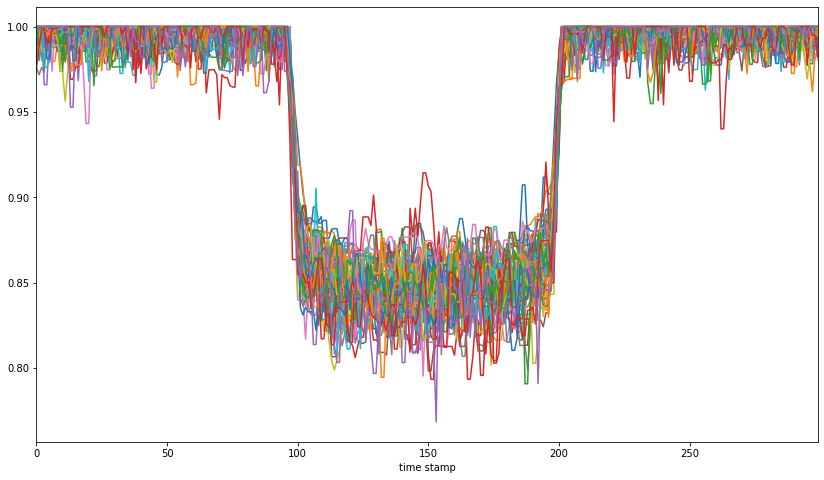

In [33]:
# Normalizing
labels = pickle.load(open("/content/drive/My Drive/ar_data/labels_pn_55.pickle",'rb'))
lbdf = pd.DataFrame(data=labels)
lbdfsq = lbdf.pow(2) #square of labels
lbdfsqm = lbdfsq.mean().mean() #mean of squared labels
lbdfsqmt = 2*lbdfsqm

t_avgarr = (s_avgarr-(1-lbdfsqmt))/lbdfsqmt # Like ariel's preprocessing

#pickle.dump(t_avgarr, open('/content/drive/My Drive/ar_data/features_as_ariel.pickle', 'wb'))

# Let's visualize how an time  series instance looks like

testdf = pd.DataFrame(data=t_avgarr[61])
testdf=testdf.transpose()
testdf.index.name = "time stamp"
testdf.plot(legend=False, figsize=(14,8))#.get_figure()


In [34]:
# We will repeat the process for test dataset

avgarr = pickle.load(open("/content/drive/My Drive/ar_data/test_avaraged_features.pickle",'rb'))
s_avgarr = np.zeros((629,55,300))

for i in range(0,629):
  #print(i)
  avgdf = pd.DataFrame(data= avgarr[i])
  avgdf = avgdf.rolling(3, axis=1, min_periods=1).median()
  avgdf = avgdf.clip_upper(1,axis=1)
  s_avgarr[i] = avgdf.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  if __name__ == '__main__':


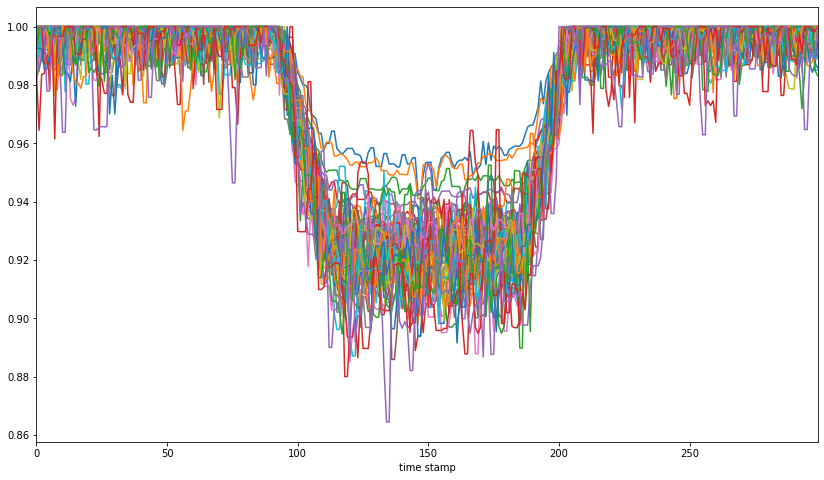

In [35]:
t_avgarr = (s_avgarr-(1-lbdfsqmt))/lbdfsqmt # Like ariel's preprocessing

testdf = pd.DataFrame(data=t_avgarr[0])
testdf=testdf.transpose()
testdf.index.name = "time stamp"
testdf.plot(legend=False, figsize=(14,8))#.get_figure()


#### Sclicing the training dataset for train and evaluation And method for making result array

Since Ariel did not uploaded the result yet, we will take a small portion of our train dataset to test. We will make the prediction with the test dataset, that provided by Ariel.

In [0]:
def slice_x(inp_x):
  
  inp_x_tr = inp_x[:1100,:]
  inp_x_ts = inp_x[1100:1400,:]
  test_x = inp_x[1400:,:]

  return inp_x_tr,inp_x_ts,test_x

def slice_y(inp_y):
  inp_y_tr = inp_y[:1100,:]
  inp_y_ts = inp_y[1100:1400,:]
  test_y = inp_y[1400:,:]

  return inp_y_tr,inp_y_ts,test_y

# Method for making result array
def make_result_array(prediction):
  t = np.zeros((62900,55))
  l=0
  k =0
  i =0
  print('creating array...')
  for i in range(0,629):
    #print(i,prediction[i,k])
    for j in range(0,100):
      #print(l)
      t[l] = prediction[i]
      l = l+1

  #if(prediction[1]==t[124]):
   # print('checked...')
  print("done...")
  return t 


Loading and preparing train test and labels

In [0]:
inp_y = pickle.load(open("/content/drive/My Drive/ar_data/labels_pn_55.pickle", 'rb'))
inp_y_tr, inp_y_ts, test_y = slice_y(inp_y)

inp_x = pickle.load(open("/content/drive/My Drive/ar_data/features_as_ariel.pickle", 'rb'))
inp_x_tr, inp_x_ts,test_x = slice_x(inp_x)

#### Models: CNN and LCN

In [0]:
def cnn(inp_x_tr, inp_y_tr, inp_x_ts, inp_y_ts):
  inp = Input(shape=(55,300))
  conv11 = Conv1D(275, kernel_size=2, padding="valid",data_format="channels_first", activation='relu')(inp)
  pool11 = MaxPooling1D(pool_size=2,data_format="channels_first")(conv11)
  conv12 = Conv1D(200, kernel_size=2, padding="valid",data_format="channels_first", activation='relu')(pool11)
  pool12 = MaxPooling1D(pool_size=2,data_format="channels_first")(conv12)
  conv13 = Conv1D(150, kernel_size=2, padding="valid",data_format="channels_first", activation='relu')(pool12)
  conv14 = Conv1D(75, kernel_size=2, padding="valid",data_format="channels_first", activation='relu')(conv13)
  pool13 = MaxPooling1D(pool_size=2,data_format="channels_first")(conv14)
  flat1 = Flatten()(pool13)

  output = Dense(55, activation='linear')(flat1)
  
  model = Model(inputs=inp, outputs=output)
  model.summary()
  
  adamp = keras.optimizers.Adam(lr=0.0006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #opt = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
  lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.9)
  #er_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
  
  model.compile(loss='mse',optimizer=adamp,metrics=[r2_keras,'mse','mae'])
  history = model.fit(inp_x_tr, inp_y_tr, epochs=500, validation_data=(inp_x_ts, inp_y_ts), batch_size=30, shuffle=False, verbose=1, callbacks=[lr_reduction])
  
  return model,history

In [0]:
def lcn(inp_x_tr, inp_y_tr, inp_x_ts, inp_y_ts):
  inp = Input(shape=(55,300))
  l1 = LocallyConnected1D(275, kernel_size=(2), padding="valid",data_format="channels_first", activation='relu')(inp)
  #pool11 = MaxPooling1D(pool_size=2,data_format="channels_first")(conv11)
  l2 = LocallyConnected1D(200, kernel_size=(2), padding="valid",data_format="channels_first", activation='relu')(l1)
  #pool12 = MaxPooling1D(pool_size=2,data_format="channels_first")(conv12)
  l3 = LocallyConnected1D(150, kernel_size=(2), padding="valid",data_format="channels_first", activation='relu')(l2)
  l4 = LocallyConnected1D(75, kernel_size=(2), padding="valid",data_format="channels_first", activation='relu')(l3)
  #pool13 = MaxPooling1D(pool_size=2,data_format="channels_first")(conv14)
  flat1 = Flatten()(l4)

  output = Dense(55, activation='linear')(flat1)
  
  model = Model(inputs=inp, outputs=output)
  model.summary()
  
  adamp = keras.optimizers.Adam(lr=0.0006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #opt = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
  lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1, factor=0.9)
  #er_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
  
  model.compile(loss='mse',optimizer=adamp,metrics=[r2_keras,'mse','mae'])
  history = model.fit(inp_x_tr, inp_y_tr, epochs=500, validation_data=(inp_x_ts, inp_y_ts), batch_size=30, shuffle=False, verbose=1, callbacks=[lr_reduction])
  
  return model,history

CNN

In [40]:
cnn_avg,cnn_avg_his = cnn(inp_x_tr, inp_y_tr, inp_x_ts, inp_y_ts)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 55, 300)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 275, 299)          30525     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 275, 149)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 200, 148)          110200    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 200, 74)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 150, 73)           60150     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 75, 72)            2257

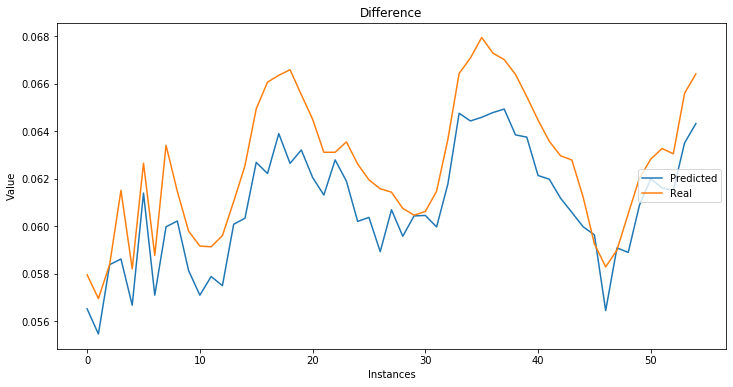

In [41]:
# Let's predict our small test data

cnn_prediction = cnn_avg.predict(test_x)

# now let's see the difference between real radii and predicted radii
plt.figure(figsize=(12,6))
#plt.plot(mlp_ari_his.history['r2_keras'])
plt.plot(cnn_prediction[0])
plt.plot(test_y[0])
#plt.plot(mlp_max_his.history['r2_keras'])
plt.title('Difference')
plt.ylabel('Value')
plt.xlabel('Instances')
plt.legend(['Predicted','Real'], loc='center right')
#plt.savefig('comp_r2.png')
plt.show()


LCN

In [42]:
lcn_ari,lcn_ari_his = lcn(inp_x_tr, inp_y_tr, inp_x_ts, inp_y_ts)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 55, 300)           0         
_________________________________________________________________
locally_connected1d_1 (Local (None, 54, 275)           8924850   
_________________________________________________________________
locally_connected1d_2 (Local (None, 53, 200)           5840600   
_________________________________________________________________
locally_connected1d_3 (Local (None, 52, 150)           3127800   
_________________________________________________________________
locally_connected1d_4 (Local (None, 51, 75)            1151325   
_________________________________________________________________
flatten_3 (Flatten)          (None, 3825)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 55)                2104

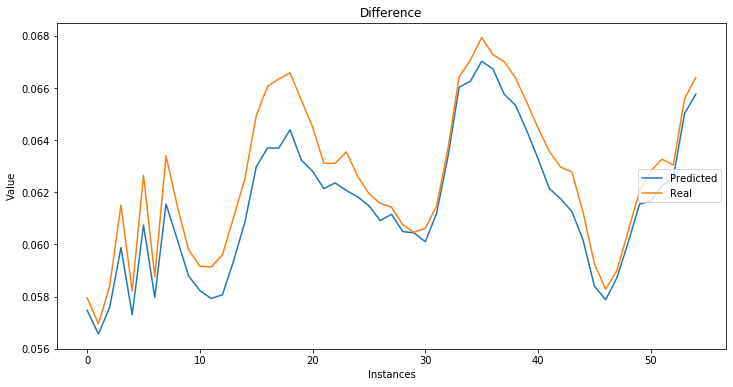

In [43]:
# Let's predict our small test data

lcn_prediction = lcn_ari.predict(test_x)

# now let's see the difference between real radii and predicted radii
plt.figure(figsize=(12,6))
plt.plot(lcn_prediction[0])
plt.plot(test_y[0])

plt.title('Difference')
plt.ylabel('Value')
plt.xlabel('Instances')
plt.legend(['Predicted','Real'], loc='center right')
#plt.savefig('comp_r2.png')
plt.show()


#### Making result array. 

The predicted relative radii from test dataset must be in (62900,55) format.

In [0]:
test_feature = pickle.load(open("/content/drive/My Drive/ar_data/test_features_as_ariel.pickle", 'rb'))
prediction_cnn = cnn_avg.predict(test_feature)
prediction_lcn = lcn_ari.predict(test_feature)

In [52]:
res_cnn = make_result_array(prediction_cnn)
res_lcn = make_result_array(prediction_lcn)

creating array...
done...
creating array...
done...


In [0]:
np.savetxt('/content/drive/My Drive/ar_data/outputs/result_cnn.txt', res_cnn, fmt='%.20f')
np.savetxt('/content/drive/My Drive/ar_data/outputs/result_lcn.txt', res_lcn, fmt='%.20f')